Implements Novak's *AN EXPERIMENT IN COMPUTATIONAL COMPOSITION (1989)* to create training set for 3D-GANs

In [3]:
%pylab inline

import math
import numpy as np

Populating the interactive namespace from numpy and matplotlib


### Utilities

In [2]:
# returns the "max entropy" for a list of "n" elements
def max_H(n):
    return H(np.array([1/n]*n))

In [3]:
# normalizes "prob"
def normalize(prob):
    return prob / np.sum(prob)

In [4]:
# flattens a grouped probability list
def flat(arr):
    return [i for tup in arr for i in tup]

### Scores

In [5]:
# entropy of a given list of probabilities
def H(prob):
    if not 0.99999 <= np.sum(prob) <= 1.0001:
        print("Probabilities must sum to 1.0. Use 'normalize(arr)'.")
        return 
    
    _s = 0
    for i in prob:
        if(i > 0):
            _s += i*math.log2(1.0/i)
    return _s

In [6]:
# returns visual information
#  internal VI := probabilities are selected from the same row 
#  external VI := probabilities are selected from the same column 
def VI(prob, c = None):
    if c == None:
        c = max_H(len(prob))
    return c - H(normalize(prob))

### Calculate all scores

In [7]:
# calculates "VI_int" and "VI_ext" scores from visual entity matrix "O"
# gene = gene index                        (row)
# param = [ group_index, param_index ]     (column)
def calculate_VIs(O, gene, param):
    VI_int = VI(normalize( flat(O[gene,:]) ))
    VI_ext = VI(normalize( [i[param[1]] for i in O[:,param[0]]] ))
    return VI_int, VI_ext

In [8]:
def calculate_pareto(vi_i_p, vi_e_p, vi_i, vi_e):
    c_i = vi_i - vi_i_p
    c_e = vi_e - vi_e_p
    
    if c_i < 0 or c_e < 0:
        return -1
    elif c_i > 0 or c_e > 0:
        return 1
    else:
        return 0

### Mutation method

In [9]:
# mutates the given visual entity matrix "0"
def mutate(O, ran):
    def _mut(mat, gene_index=None, index=None, value=None):
        # copy the matrix
        _O = mat.copy()

        ## choose a gene strip randomly
        if gene_index is None:
            gene_index = random.randint(0, len(_O))
        gene = _O[gene_index]

        ## choose a parameter in gene strip randomly
        if index is None:
            group_index = random.randint(0, len(gene))
            index = ( group_index, random.randint(0, len(gene[group_index])) )

        ## calculate prior VI scores
        VI_i_p, VI_e_p = calculate_VIs(_O, gene_index, index)

        ## choose a mutation value randomly
        if value is None:
            value = random.random()*ran*gene[index[0]][index[1]]

        ## choose an operation randomly (add(1), substract(-1), no_change(0))
        operation = random.choice([-1,0,1])

        ## choose one neighbor randomly and adjust its value (left(-1), right(1))
        neighbor = random.randint(0, len(gene[index[0]]))
        while neighbor == index[1]:
            neighbor = random.randint(0, len(gene[index[0]]))
#         if index[1] == 0:
#             neighbor = 1
#         elif index[1] == len(gene[index[0]])-1:
#             neighbor = -1
#         else:
#             neighbor = random.choice([-1,1])

        ## apply mutation to the gene
        gene[index[0]][index[1]] += operation*value
        gene[index[0]][neighbor] += -operation*value
#         gene[index[0]][index[1]+neighbor] += -operation*value

        ## calculate VI scores
        VI_i, VI_e = calculate_VIs(_O, gene_index, index)

        ## calculate decisions
        pareto = calculate_pareto(VI_i_p, VI_e_p, VI_i, VI_e)
        
        # -1 -> pick different gene
        #  0 -> pick different mutation value
        #  1 -> accept mutation
        if pareto == -1:
            return _mut(mat)
        elif pareto == 0:
            return _mut(mat, gene_index=gene_index, index=index)
        elif pareto == 1:
            return _O
        
    try:
        return _mut(O)
    except RecursionError as re:
        print(".", end='')
        return O

### Show composition

In [10]:
def pick_color(i1, i2):
    threshold = 0.4
    if i1 <= threshold and i2 <= threshold:
        return 0
    elif i1 <= threshold and i2 > threshold:
        return 1
    elif i1 > threshold and i2 <= threshold:
        return 1
    elif i1 > threshold and i2 > threshold:
        return 1
    

# returns image 
def get_image(arr, size=(400,400), lineWeight=4, value=1.0, fill=True, stroke=True):
    im = np.ones(size[:2], dtype=np.float32)
    
    ## background
    if fill is True:
        _s = [0,0]
        for i, item in enumerate(arr[-2:][0]):
            grid_y = int(arr[:2][0][i])
            _s[1] = 0
            for j, item2 in enumerate(arr[-2:][1]):
                grid_x = int(arr[:2][1][j])
                
                im[_s[1]:_s[1] + grid_x,
                   _s[0]:_s[0] + grid_y] = pick_color(item, item2)
                
                _s[1] += grid_x
            _s[0] += grid_y
    
    
    ## grid lines
    if stroke is True:
        # columns
        _s = 0
        for item in arr[:2][0]:
            im[:,_s:_s+lineWeight] = value
            _s += int(item)

        # rows
        _s = 0
        for item in arr[:2][1]:
            im[_s:_s+lineWeight,:] = value
            _s += int(item)
    
        # right and bottom borders
        im[:,-lineWeight:] = value
        im[-lineWeight:,:] = value
    
    return im
    
# displays composition as image
def show_comp(arr, size=(400,400), lineWeight=4, value=0.0, fill=True, stroke=True, legend=False):
    im = get_image(arr, size, lineWeight, value, fill, stroke)
    
    imshow(im, cmap='gray')
    if legend is True:
        colorbar()

In [11]:
## shows the matrix
def show_all(O, size=(400,400), lineWeight=4, value=0.0, fill=True, stroke=True, legend=False):
    figure(figsize=(len(O)*2.5, 30))
    
    for j in np.arange(len(O)):
        plt.subplot(1, len(O), j+1, 
                    title="({}) Ent: {}".format(j, round(H( normalize( flat(O[j])) ), 2)))
        show_comp(O[j], size=size, lineWeight=lineWeight, value=value, fill=fill, stroke=stroke, legend=legend)

### Run evolution and show intermediate results

In [12]:
## evolve 'O' for 'n' iterations, and display compositions in every 'm' (if 'show' is true)
def evolve(O, n=500, m=100, range=0.1, show=False, fill=True, stroke=False, size=(400, 400)):
    if show is True:
        figure(figsize=(len(O)*2.5, (n//m)*3))
    count = 1

    # run n iterations
    for i in np.arange(n):
        # mutates the matrix
        O = mutate(O, range)

        if show is True and i%m == m-1:
            for j in np.arange(len(O)):
                plt.subplot(n//m, len(O), count, 
                            title="({}) Ent: {} , Iter: {}".format(j, 
                                                                   round(H( normalize( flat(O[j])) ), 2), 
                                                                   i))
                show_comp(O[j], size=size, stroke=stroke, fill=fill)
                count+=1
                
    # returns evolved matrix
    return O

### Testing

In [13]:
# one 2D unevolved visual entity matrix

# total size of the image (based on the contents of O)
SIZE = (300, 300)

O = np.array([[(100,100,100), (100,100,100), (0.5,0.5,0.5), (0.5,0.5,0.5)],
              [(100,100,100), (100,100,100), (0.5,0.5,0.5), (0.5,0.5,0.5)],
              [(100,100,100), (100,100,100), (0.5,0.5,0.5), (0.5,0.5,0.5)],
              [(100,100,100), (100,100,100), (0.5,0.5,0.5), (0.5,0.5,0.5)]])

In [18]:
# one 3D unevolved visual entity matrix 

# total size of the image (based on the contents of O)
SIZE = (300, 300, 300)

# 'n' compositions, 'm'**2 grid cells
n = 5
m = 8
O = np.ones((n, 6, m))*(SIZE[0]//m)
O[:,3:,:] = 0.5

In [19]:
O = evolve(O, n=2000, range=0.05, show=False, size=SIZE)

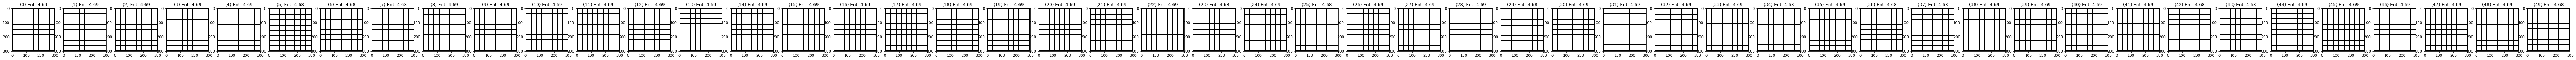

In [16]:
show_all(O, size=SIZE, fill=True, stroke=True, lineWeight=4)

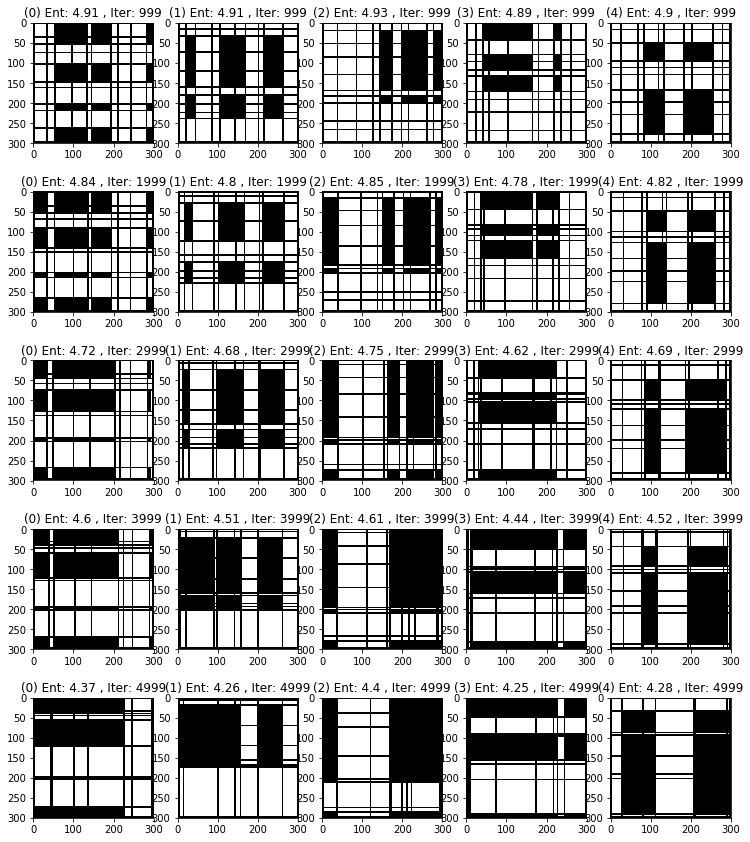

In [17]:
O = evolve(O, n=5000, m=1000, range=0.05, show=True, stroke=True, fill=True, size=SIZE)

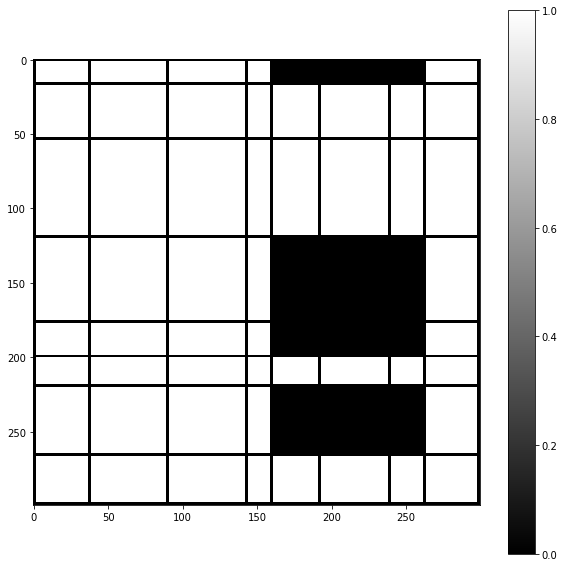

In [20]:
# display one composition 
n = 1
figure(figsize=(10,10))
show_comp(O[n], size=SIZE, legend=True, fill=True, stroke=True, lineWeight=2)

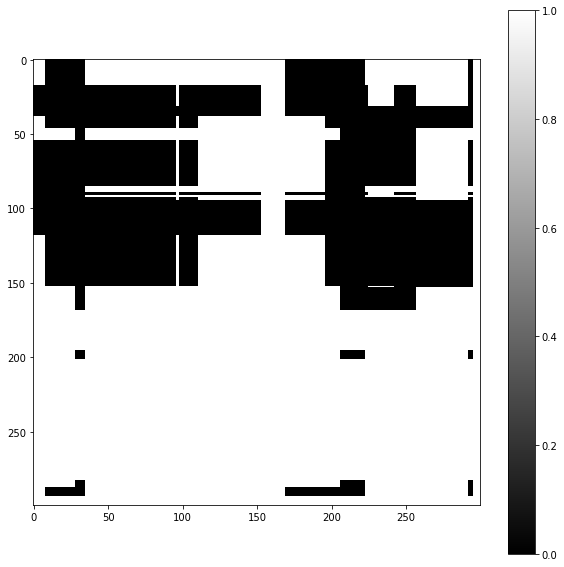

In [19]:
# superimpose all compositions
figure(figsize=(10,10))
im = np.zeros(SIZE[:2])
for item in O:
    im += get_image(item, size=SIZE, stroke=False)

im -= np.min(im)
im /= np.max(im)
im = np.round(im)

imshow(im, cmap='gray')
colorbar()

### Show 3D

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [37]:
def pick_fill(i1, i2, i3):
    threshold = 0.3
    if i1 <= threshold and i2 <= threshold and i3 <= threshold:
        return 0
    elif i1 <= threshold and i2 > threshold and i3 <= threshold:
        return 0
    elif i1 > threshold and i2 <= threshold and i3 <= threshold:
        return 1
    elif i1 > threshold and i2 > threshold and i3 <= threshold:
        return 0
    elif i1 <= threshold and i2 <= threshold and i3 > threshold:
        return 1
    elif i1 <= threshold and i2 > threshold and i3 > threshold:
        return 0
    elif i1 > threshold and i2 <= threshold and i3 > threshold:
        return 1
    elif i1 > threshold and i2 > threshold and i3 > threshold:
        return 0
    else:
        return 0

In [23]:
def create_voxel(O, size=(30,30,30), compSize=(300,300,300)):
    # iteratively sum vertices of each dimension
    _O = O[:3].copy()
    for arr in _O:
        _s = 0
        for i, item in enumerate(arr):
            _s += item
            arr[i] = _s
            
    # blocks
    _H = O[-3:]
    _S = compSize[0]/size[0]
    voxels = np.zeros(size)

    for i, _i in enumerate(_O[0]):
        for j, _j in enumerate(_O[1]):
            for k, _k in enumerate(_O[2]):
                if pick_fill(_H[0][i], _H[1][j], _H[2][k]) == 1:
                    voxels[int(_i/_S):int((_i+O[0][i])/_S),
                           int(_j/_S):int((_j+O[1][j])/_S),
                           int(_k/_S):int((_k+O[2][k])/_S)] = 1
    return voxels

In [24]:
# show one composition
def show_voxel(O, size=(30,30,30), compSize=(300,300,300)):
    fig = plt.figure(figsize=(5,4))
    ax = fig.gca(projection='3d', 
                 title="Ent: {}".format( H( normalize( flat(O)) )))
    ax.voxels(create_voxel(O, size=size, compSize=compSize), 
              edgecolor='k')
    plt.show()
    
# show all compositions
def show_voxels(O, size=(30,30,30), compSize=(300,300,300)):
    fig = plt.figure(figsize=(len(O)*5, 4))
    for i in arange(0, len(O)):
        ax = fig.add_subplot(1,len(O),i+1, 
                             projection='3d', 
                             title="({}) Ent: {}".format(i, round( H( normalize( flat(O[i])) ), 2) ))
        ax.voxels(create_voxel(O[i], size=size, compSize=compSize), 
                  edgecolor='k')
    plt.show()

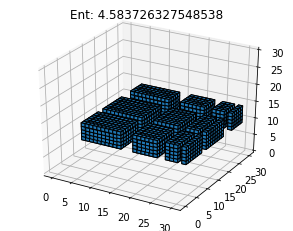

In [25]:
show_voxel(O[0], size=(30,30,30), compSize=SIZE)

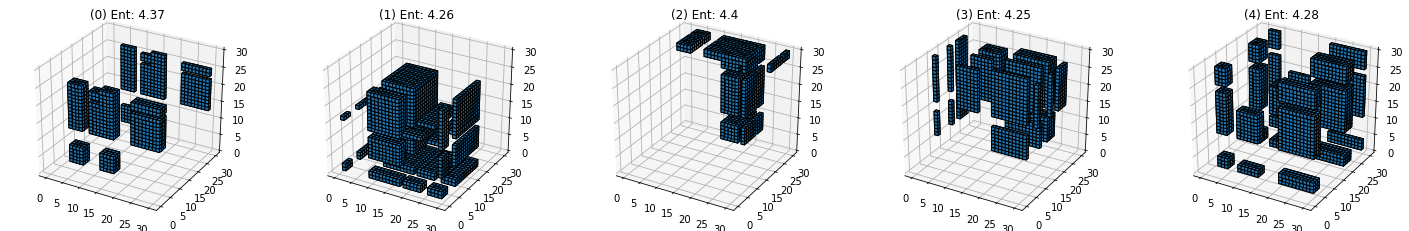

In [35]:
show_voxels(O, size=(30,30,30), compSize=SIZE)

### .mat files

In [2]:
from scipy.io import loadmat, savemat
import datetime

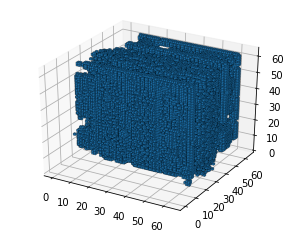

In [69]:
fig = plt.figure(figsize=(5, 4))
im = loadmat('biasfree_5000.mat')['instance']

ax = fig.gca(projection='3d')
ax.voxels(im, edgecolor=matplotlib.colors.colorConverter.to_rgba('black', alpha=.1), alpha=0.5)
plt.show()

In [47]:
# create dictionary (format Wed Sep 17 13:21:09 2014)
now = datetime.datetime.now()
obj = {'__header__': str.encode('MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: ' + now.strftime("%a %b %d %H:%M:%S %Y")),
       '__version__': '1.0',
       '__globals__': [],
       'instance': create_voxel(O[0], size=(30,30,30), compSize=SIZE)}

## write mat file
savemat('compositions/comp.mat', obj, do_compression=True)

#### Create the training set

In [1]:
def save_mat(filename, O, comp=True):
    # create dictionary (format Wed Sep 17 13:21:09 2014)
    now = datetime.datetime.now()
    obj = {'__header__': str.encode('MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: ' + 
                                    now.strftime("%a %b %d %H:%M:%S %Y")),
           '__version__': '1.0',
           '__globals__': [],
           'instance': create_voxel(O, size=(30,30,30), compSize=SIZE)}

    ## write mat file
    savemat(filename, obj, do_compression=comp)

In [52]:
# total size of the image (based on the contents of O)
SIZE = (300, 300, 300)

N = 5000
n = 5
m = 8

for i in arange(200, N//n):
    O = np.ones((n, 6, m))*(SIZE[0]//m)
    O[:,3:,:] = 0.5

    O = evolve(O, n=2000, range=0.1, show=False, size=SIZE)

    for j in arange(0, n):
        save_mat('compositions/comp'+str(i*n+j)+'.mat', O[j])

#### Output files

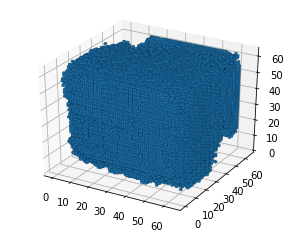

In [9]:
fig = plt.figure(figsize=(5, 4))
im = loadmat('output/biasfree_4000.mat')['instance']

ax = fig.gca(projection='3d')
ax.voxels(im, edgecolor=matplotlib.colors.colorConverter.to_rgba('black', alpha=.1), alpha=0.5)
plt.show()

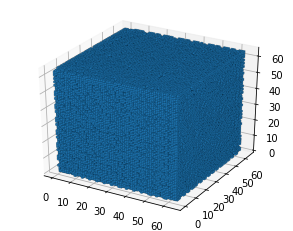

In [7]:
fig = plt.figure(figsize=(5, 4))
im = loadmat('output/biasfree_7800.mat')['instance']

ax = fig.gca(projection='3d')
ax.voxels(im, edgecolor=matplotlib.colors.colorConverter.to_rgba('black', alpha=.1), alpha=0.5)
plt.show()

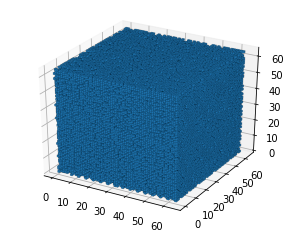

In [5]:
fig = plt.figure(figsize=(5, 4))
im = loadmat('output/biasfree_9900.mat')['instance']

ax = fig.gca(projection='3d')
ax.voxels(im, edgecolor=matplotlib.colors.colorConverter.to_rgba('black', alpha=.1), alpha=0.5)
plt.show()

### Export .mat file as .json

In [8]:
import numpy as np
import json

mat = loadmat('output/biasfree_5000.mat')

with open('data.txt', 'w') as outfile:
    json.dump(mat['instance'].tolist(), outfile)